# Finding Anomalies for an Entire Era
This notebook is for compiling an Excel file detailing all of the anomalies in a single era. 

Specify the Era:

1. Load the appropriate model
2. Import all runs/lumisections that pass the DCS flags
3. Predict on the lumisections
4. Loop over each run
    * Split the long combined lumisection, data, and predictions arrays with their respective run number
    * Store the predictions with the specific run in a dictionary
    * Keep a running list of each dictionary
5. Calculate the losses and binary losses
6. Analyze the anomalies
7. Identify Anomaly Types
8. Merge Excel files for whole Ring
9. Save specific LS in .png plot (Data, Predictions, Losses, and Binary Losses)
10. Optional (Save plot of each anomalous lumisection)

Folders:
* Main folder --> /eos/user/a/alaperto/TkDQM/Devel/PixelRing2NMF/Development/models/
* Data by Luka --> /eos/user/l/llambrec/dialstools-output/
* Original Jake --> /eos/user/j/jomorris/SWAN_projects/NMF Testing/

In [1]:
%%time
# imports

import os
import sys
import json
import time
import joblib
import importlib
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plottools as plottools

from nmf2d import NMF2D

import functions
importlib.reload(functions);
from functions import *
    
#Used to load an extension that can skip the remaining execution of a cell. 
#Used to skip the training so we don't constantly retrain a model
%load_ext skip_kernel_extension
%reload_ext skip_kernel_extension

optimized_powerGroupStringsList = np.array(['FPix_BmO_D3_ROG4','FPix_BmO_D2_ROG4','FPix_BmO_D1_ROG4','FPix_BmO_D3_ROG3','FPix_BmO_D2_ROG3','FPix_BmO_D1_ROG3','FPix_BmO_D3_ROG2','FPix_BmO_D2_ROG2','FPix_BmO_D1_ROG2','FPix_BmO_D3_ROG1','FPix_BmO_D2_ROG1','FPix_BmO_D1_ROG1','FPix_BmI_D3_ROG1','FPix_BmI_D2_ROG1','FPix_BmI_D1_ROG1','FPix_BmI_D3_ROG2','FPix_BmI_D2_ROG2','FPix_BmI_D1_ROG2','FPix_BmI_D3_ROG3','FPix_BmI_D2_ROG3','FPix_BmI_D1_ROG3','FPix_BmI_D3_ROG4','FPix_BmI_D2_ROG4','FPix_BmI_D1_ROG4','FPix_BpO_D1_ROG4','FPix_BpO_D2_ROG4','FPix_BpO_D3_ROG4','FPix_BpO_D1_ROG3','FPix_BpO_D2_ROG3','FPix_BpO_D3_ROG3','FPix_BpO_D1_ROG2','FPix_BpO_D2_ROG2','FPix_BpO_D3_ROG2','FPix_BpO_D1_ROG1','FPix_BpO_D2_ROG1','FPix_BpO_D3_ROG1','FPix_BpI_D1_ROG1','FPix_BpI_D2_ROG1','FPix_BpI_D3_ROG1','FPix_BpI_D1_ROG2','FPix_BpI_D2_ROG2','FPix_BpI_D3_ROG2','FPix_BpI_D1_ROG3','FPix_BpI_D2_ROG3','FPix_BpI_D3_ROG3','FPix_BpI_D1_ROG4','FPix_BpI_D2_ROG4','FPix_BpI_D3_ROG4'])
#A list of all of the quarters of the detector
QUARTERS = np.array([['FPix_BmI_D3_ROG1','FPix_BmI_D3_ROG2','FPix_BmI_D3_ROG3','FPix_BmI_D3_ROG4','FPix_BmI_D2_ROG1','FPix_BmI_D2_ROG2','FPix_BmI_D2_ROG3','FPix_BmI_D2_ROG4','FPix_BmI_D1_ROG1','FPix_BmI_D1_ROG2','FPix_BmI_D1_ROG3','FPix_BmI_D1_ROG4'], ['FPix_BmO_D3_ROG1','FPix_BmO_D3_ROG2','FPix_BmO_D3_ROG3','FPix_BmO_D3_ROG4','FPix_BmO_D2_ROG1','FPix_BmO_D2_ROG2','FPix_BmO_D2_ROG3','FPix_BmO_D2_ROG4','FPix_BmO_D1_ROG1','FPix_BmO_D1_ROG2','FPix_BmO_D1_ROG3','FPix_BmO_D1_ROG4'], ['FPix_BpI_D1_ROG1','FPix_BpI_D1_ROG2','FPix_BpI_D1_ROG3','FPix_BpI_D1_ROG4','FPix_BpI_D2_ROG1','FPix_BpI_D2_ROG2','FPix_BpI_D2_ROG3','FPix_BpI_D2_ROG4','FPix_BpI_D3_ROG1','FPix_BpI_D3_ROG2','FPix_BpI_D3_ROG3','FPix_BpI_D3_ROG4'], ['FPix_BpO_D1_ROG1','FPix_BpO_D1_ROG2','FPix_BpO_D1_ROG3','FPix_BpO_D1_ROG4','FPix_BpO_D2_ROG1','FPix_BpO_D2_ROG2','FPix_BpO_D2_ROG3','FPix_BpO_D2_ROG4','FPix_BpO_D3_ROG1','FPix_BpO_D3_ROG2','FPix_BpO_D3_ROG3','FPix_BpO_D3_ROG4']])

CPU times: user 1.79 s, sys: 589 ms, total: 2.38 s
Wall time: 4.2 s


|        2024 Era     | B | C | D | E | E | F |   F  |   G  |   H  |   I  |   I  |
|:-------------------:|:-:|:-:|:-:|:-:|:-:|:-:|:----:|:----:|:----:|:----:|:----:|
|       Version       | 1 | 1 | 1 | 2 | 1 |   1  |   1  |   1  |   1  |   2  |
|        Period       | 1 | 1 | 1 | 1 | 1 | 1 |   2  |   2  |   2  |   2  |   2  |
|    Model Ring 1     | X | 1 | 1 | 1 | 1 | 1 |   2  |   2  |   2  |   2  |   2  |
|    Model Ring 2     | 5 | 5 | 5 | 5 | 5 | 5 |   7  |   7  |   7  |   7  |   7  |

|        2025 Era     | B | C | C | C | D | E | F |   F  |   G   |
|:-------------------:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:--:|:----:|
|       Version       | 1 | 1 | 1 | 2 | 1 | 1 | 1 |   2  |   1  |
|        Period       | 3 | 3 | 4 | 4 | 4 | 4 | 4 |   4  |   4  |
|    Model Ring 1     | X | 3 | 8 | 8 | 8 | 8 | X |   X  |   X  |
|    Model Ring 2     | 7 | 7 | 7 | 7 | 7 | 7 |  7   |  7   |  7  |


# Important Variables

In [2]:
#Select the era: import and search for anomalies
RING = 2
#YEAR, ERA, VERSION, PERIOD = 2025, "C", 1, 3
#YEAR, ERA, VERSION, PERIOD = 2025, "F", 1, 4
YEAR, ERA, VERSION, PERIOD = 2024, "I", 2, 2

#YEAR, ERA, VERSION, PERIOD = 2025, "B", 1, 2

#ring 1 --> 1 - 2 - 3 - 4
#ring 2 --> 5 - 7 - 7 - 7
#number, model_period, type = 5, 1, 1
number, model_period, type = 7, 3, 1

model_name = f'model_{number}_PXRing_{RING}_period_{model_period}_type_{type}.pkl'

#For both
ANOMALY_CUTOFF = 40 #Threshold on fraction of powergroup that is Bad --> Define LS as anomalous

# Model thresholds Ring 1
if RING == 1:
    EDITION = 1
    if YEAR == 2024:
        LOSS_THRESHOLD = 4e5 #Threshold on Loss of the ROC --> Define ROC as Bad
    elif YEAR == 2025:
        LOSS_THRESHOLD = 9e5
    #EDITION = 4 #Special test for 900 LS, model 8
# Model thresholds Ring 2
elif RING == 2:
    EDITION = 2
    LOSS_THRESHOLD = 1e5 #Threshold on Loss of the ROC --> Define ROC as Bad
    #EDITION = 3 #Special for splitting in half era 2024G_v1 and 2025D_v1

#Plotting Globals
DO_PLOTTING = False #Whether or not to plot EVERY anomalous lumisection in this era. WARNING: Takes a long time. ~13mins for 93 anomalies
SAVE_FIGS = False #Whether or not to also SAVE the plot of every anomalous lumisection. DO_PLOTTING must also be True for the images to be saved

#Some light calculation of important variables
file = f'../data/ZeroBias-Run{YEAR}{ERA}-PromptReco-v{VERSION}-DQMIO-PixelPhase1-Phase1_MechanicalView-PXForward-clusters_per_SignedDiskCoord_per_SignedBladePanelCoord_PXRing_{RING}.parquet'
oms_json = f'../omsdata/omsdata_Run{YEAR}{ERA}-v{VERSION}.json'
#ring_num = int(file[-9]) #The -9th character is ALWAYS the ring number for our data
ring_num = RING

#The directory name to use for 
DIR_NAME = f"../results/output_{YEAR}{ERA}_v{VERSION}_period_{PERIOD}_PXRing_{RING}_edition_{EDITION}" 
if not os.path.exists(DIR_NAME): os.makedirs(DIR_NAME)

## 1. Load the Model

In [3]:
nmf_file = f'../models/{model_name}'
nmf = joblib.load(nmf_file)

print(f"Loaded Model: {nmf_file}")
print(f"Model Shape: {nmf.xshape}")

Loaded Model: ../models/model_7_PXRing_2_period_3_type_1.pkl
Model Shape: [136, 48]


/cvmfs/sft.cern.ch/lcg/views/LCG_108_cuda/x86_64-el9-gcc13-opt/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MiniBatchNMF from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## 2. Import all runs/lumisections that pass the DCS flags
Import the entire era at once so we only have to go to the disk once. 

Use the OMS JSON to filter only the lumisections that pass the DCS flags. Helps to reduce unnecessary predictions on bad lumisections

In [4]:
%%time
#Any logic for when parts of the detector are disabled. 
extra_filters = []
#Logic for Era F period 1/2 and 2025 Era Cv1 period 3/4
if YEAR == 2024 and ERA == "F" and PERIOD == 1:
    extra_filters.append(('run_number', '<', 382799))
elif YEAR == 2024 and ERA == "F" and PERIOD == 2:
    extra_filters.append(('run_number', '>=', 382799))
elif YEAR == 2024 and ERA == "G" and RING == 2 and EDITION == 2: #Split in half 2024G_v1, too heavy
    extra_filters.append(('run_number', '<', 384684))
elif YEAR == 2024 and ERA == "G" and RING == 2 and EDITION == 3: #Split in half 2024G_v1, too heavy
    extra_filters.append(('run_number', '>', 384684))
elif YEAR == 2025 and ERA == "C" and VERSION == 1 and PERIOD == 3:
    extra_filters.append(('run_number', '<=', 392668))
elif YEAR == 2025 and ERA == "C" and VERSION == 1 and PERIOD == 4:
    extra_filters.append(('run_number', '>', 392668))
elif YEAR == 2025 and ERA == "C" and VERSION == 2 and PERIOD == 4:
    extra_filters.append(('run_number', '<', 393512))#Machine Development runs
elif YEAR == 2025 and ERA == "D" and RING == 2 and EDITION == 2: #Split in half 2025D_v1, too heavy
    extra_filters.append(('run_number', '<', 395432))
elif YEAR == 2025 and ERA == "D" and RING == 2 and EDITION == 3: #Split in half 2025D_v1, too heavy
    extra_filters.append(('run_number', '>', 395432))
elif YEAR == 2024 and ERA == "B": #Avoid HV bias scan
    extra_filters.append(('run_number', '>=', 378985))
elif YEAR == 2025 and ERA == "B": #Avoid HV bias scan
    extra_filters.append(('run_number', '>=', 391688))

#Testing the function to import AND filter an entire era at once
multi_lumi_data, all_runs, lumis, df = extract_data_whole_era(file, oms_json, extra_filters=extra_filters)
del df
all_runs, indices = np.unique(all_runs, return_index=True)
indices = indices[1:] #The first index in indices is always 0, since the first number is always unique, so we discard that. 
print(f"There are {len(all_runs)} Runs and {len(lumis)} Lumisections that Pass All DCS Flags: \n", all_runs)

There are 36 Runs and 14920 Lumisections that Pass All DCS Flags: 
 [386694 386702 386703 386704 386705 386749 386753 386764 386795 386801
 386802 386803 386804 386805 386806 386807 386809 386810 386811 386812
 386813 386814 386851 386852 386853 386854 386863 386864 386872 386873
 386885 386917 386924 386925 386945 386951]
CPU times: user 4.15 s, sys: 4.16 s, total: 8.31 s
Wall time: 8.96 s


## 3. Predict on the lumisections

In [5]:
%%time

# Predict or not predict (30 mins for 100k LS)
FORCE_PREDICT = False

#Remove the cross so we can predict on it
multi_lumi_data_no_cross = remove_cross(multi_lumi_data, RING)

#Save predictions array to a file (since they take so long to produce)
pred_filename = f"{DIR_NAME}/Predictions"

if os.path.exists(pred_filename + '.npy') and FORCE_PREDICT == False:
    print(f"Predictions Already Exist!")
    print(f"Loading predictions from {pred_filename}.npy")
    mes_pred = np.load(pred_filename + '.npy')
    print(f"Shape: {mes_pred.shape}")
else:
    #If we don't already have a prediction directory then make it
    if FORCE_PREDICT: 
        print(f"FORCE_PREDICT is True. ---> Overwrite file at {pred_filename}.npy")
    else:
        print("Predictions don't exist yet! Starting Prediction. ")

    #Predict on the data
    print(f'Predicting...')
    start_time = time.time()
    mes_pred = nmf.predict(multi_lumi_data_no_cross)
    np.save(pred_filename, mes_pred)
    print(f"Done Predicting in {time.time() - start_time} Seconds!\n")

Predictions Already Exist!
Loading predictions from ../results/output_2024I_v2_period_2_PXRing_2_edition_2/Predictions.npy
Shape: (14920, 136, 48)
CPU times: user 185 ms, sys: 610 ms, total: 794 ms
Wall time: 4.83 s


## 4. Loop over each run
    * Split the long combined lumisection, data, and predictions arrays with their respective run number
    * Store the predictions with the specific run in a dictionary
    * Keep a running list of each dictionary

In [6]:
%%time
#Verbose=0: No prints. Verbose=1: Some prints. Verbose>=2: Some very long prints
verbose = 0

#Split the long combined arrays of the lumisections, the data, and the predictions
lumisections = np.split(lumis, indices)
data_arr = np.split(multi_lumi_data_no_cross, indices)
pred_arr = np.split(mes_pred, indices)

#print(pred_arr[1].shape)

#Now our data is splitted into arrays by run number, we can loop over the run numbers, generate our data_dicts and put them in a data_dict_list.
#So it is in a format ready to be used to calculate the losses and anomalies. 
#Create a list to store all of the lumisections and predictions
data_dict_list = list(np.empty_like(all_runs)) 
for index, run_number in enumerate(all_runs):
    data_dict = {}
    data_dict["run_number"] = run_number
    data_dict["lumisections"] = lumisections[index]
    data_dict["data"] = data_arr[index]
    data_dict["predictions"] = pred_arr[index]
    #Add the cross into the predictions and data
    data_dict["data_cross"] = add_cross(data_arr[index])
    data_dict["predictions_cross"] = add_cross(pred_arr[index])
    
    #Add this run to the data dict list
    data_dict_list[index] = data_dict    
    #Printing
    if verbose>0:
        print(f"Run Number: {run_number}")
        print(f"\tThere are {len(lumisections[index])} Extracted Lumisections:\n\t{lumisections[index]}\n")
    if verbose>1:
        print(data_dict)
        
if verbose>0:
    print(data_dict_list[0])
elif verbose>1:
    print(data_dict_list)

CPU times: user 1.7 s, sys: 168 ms, total: 1.86 s
Wall time: 1.87 s


## 5. Calculate the losses and binary losses
(Do this in separate loop so we can change the loss threshold)

In [7]:
%%time

#Loop over each data dictionary in the list and calculate the losses and binary losses. 
#Add these to the dictionaries as we go along. 
for index, data_dict in enumerate(data_dict_list):
    #Extract the needed info from the data_dict
    multi_lumi_data_no_cross = data_dict["data"]
    mes_pred = data_dict["predictions"]
    
    #Calculate losses
    losses = np.square(multi_lumi_data_no_cross - mes_pred)
    losses_binary = (losses > LOSS_THRESHOLD).astype(int)
    
    #Add the crosses back
    losses_cross = add_cross(losses)
    losses_binary_cross = add_cross(losses_binary)
    
    #Add new entries to the data_dict
    #This will automatically update the dictionaries in the data_dict_list
    data_dict["losses"] = losses_cross
    data_dict["losses_binary"] = losses_binary_cross

CPU times: user 1.75 s, sys: 420 ms, total: 2.17 s
Wall time: 2.17 s


## 6. Analyze the anomalies

### Analyze Each Lumisection of Each Run for Anomalies

In [ ]:
%%time

testingtime = False
verbose = False

#Create lists for tracking the anomalous lumisections in all of the runs
all_anomalous_runs = []
all_anomalous_lumisections = []
all_anomalous_powergroups = []

for i, data_dict in enumerate(data_dict_list):
    #Extract the required info from the data_dict
    run_number = data_dict["run_number"]
    lumisections = data_dict["lumisections"]
    losses_binary_cross = data_dict["losses_binary"]
    
    #Currently a list of anomalous lumisections and their powergroups
    #These arrays are prevented from getting out of sync by still appending 
    #the anomalous lumisection even if that lumisection was already marked bad with a different powergroup
    anomalous_lumisections = []
    anomalous_powergroups = []

    for index, lumisection in enumerate(lumisections):
        if verbose: print(f"Index: {index} \t Lumisection: {lumisection}")

        for j, powergroup in enumerate(optimized_powerGroupStringsList):
            #if not testingtime: print(f"Power Group String: {powergroup}")
            powerGroupSlice, diskSlice = powerGroupToIndex(powergroup, RING)

            #Access each power group in each lumisection and see if more than 40% of the bins are on
            #A bit ugly, but this was the fastest way I found. Saved about .1 seconds over saving the powergroup data to another variable. 
            if int(np.sum(losses_binary_cross[index, powerGroupSlice, diskSlice].flatten())) >= int(ANOMALY_CUTOFF/100 * losses_binary_cross[index, powerGroupSlice, diskSlice].flatten().size):
                if verbose: print(f"Anomalous Power Group: {powergroup} \t in Lumisection: {lumisection} \t with Binary Sum: {np.sum(powerGroup_data)}")
                all_anomalous_runs.append(run_number)
                anomalous_lumisections.append(lumisection)
                anomalous_powergroups.append(powergroup)
                
            #This is used to pull out specific lumisection and check their binary loss occupancy
            #if run_number == 379660 and lumisection == 291:
            #    print(f"Powergroup: {powergroup}")
            #    print(f"Powergroup Size:{losses_binary_cross[index, powerGroupSlice, diskSlice].flatten().size}")
            #    print(f"Sum of Binary Loss:{np.sum(losses_binary_cross[index, powerGroupSlice, diskSlice].flatten())}\n")
            #    save_digis_png(losses_binary_cross[index], run_number, lumisection, RING)
                
    #Update the data_dict with the anomalous lumisections and powergroups
    #I don't have a plan for them currently, but it could be useful
    data_dict["anomalous_lumisections"] = np.array(anomalous_lumisections)
    data_dict["anomalous_powergroups"] = np.array(anomalous_powergroups)
    
    #EXTEND the anomalous lumisections and powegroups to the ALL list. Extend keeps the list flat
    all_anomalous_lumisections.extend(anomalous_lumisections)
    all_anomalous_powergroups.extend(anomalous_powergroups)
    
# print(all_anomalous_runs)
# print(all_anomalous_lumisections)
# print(all_anomalous_powergroups)
# print(data_dict_list[-2])
num_anomalous_lumisections, all_anomalous_lumisections_unique = calcNumAnomalousLumisections(data_dict_list)
print(f'Resuming results...')
print(f"Era {YEAR}{ERA}_v{VERSION} (Run {all_runs[0]} to Run {all_runs[-1]})")
print(f"{num_anomalous_lumisections} Anomalous Lumisections")
#For some reason the above number can disagree with the sum of the Num_LS column in Excel. But they are never far off.
#Might happen due to lumisections appearing twice in the excel file. Like when a single lumisection has both a single disk anomaly and a multi disk anomaly
#The lumisection could be double counted. There may be more cases where this happens. 

## 7. Identify Anomaly Types
This section will identify runs in lumisections that stay the same then compare the powergroups and see if there are any multi-disk anomalies. 

If there are no repeating lumisections, then it is just a single disk anomaly. 

### Create a file summarizing all lumisections and their anomalies
#### Run_Number    Lumisection    PRT    Disk    Ring_Num    Anomaly_Type

In [ ]:
%%time
#Identify multi disk anomalies
verbose = 0
#Create a pandas dataframe that we can use to track EACH anomalous lumisection in each run
headers = ["Run_Number", "Lumisection", "Powergroup", "Disk", "Ring_Num", "Anomaly_Type"]
all_detailed_anomaly_df = pd.DataFrame(columns=headers)

#Loop over each data dict in the data dict list
for index, data_dict in enumerate(data_dict_list):
    #Extract the relavant information
    run_number = data_dict["run_number"]
    anomalous_lumisections = data_dict["anomalous_lumisections"]
    anomalous_powergroups = data_dict["anomalous_powergroups"]
    
    #If there are no anomaous lumisections or powergroups then stop this iteration
    if anomalous_lumisections.size == 0 or anomalous_powergroups.size == 0:
        continue
    

    #Create dataframe of anomalous lumisections and powergroups
    anomaly_df = pd.DataFrame({"lumisections": anomalous_lumisections, "powergroups": anomalous_powergroups})

    if verbose>0: print("Anomaly Dataframe: \n", anomaly_df, '\n')

    #Create unique arrays to pare down duplicate data
    anomalous_lumisections_unique = np.unique(anomalous_lumisections)

    #Create a list of dictionaries for easier saving to text
    dictList = np.empty_like(anomalous_lumisections_unique, dtype=dict)

    detailed_anomaly_df = pd.DataFrame(columns=headers)

    # print("AHHHHHHH\n", detailed_anomaly_df)
    if verbose>0: print('-----------------------------------------')
    #Loop over each unique lumisection
    for index, lumisection in enumerate(anomalous_lumisections_unique):
        #These values are the same for single/multi disk anomalies
        dataDict = dict.fromkeys(headers)
        dataDict["Run_Number"] = run_number
        dataDict["Lumisection"] = lumisection
        dataDict["Ring_Num"] = ring_num

        #Get the lumisection and all of the anomaly powergroups
        #If there is only one powergroup, mark it Single Disk, preparing the detailed Pandas anomaly dataframe, then move on
        #If there is multiple powergroups, iterate through each pair, breaking on the first Multi-disk anomaly after preparing the detailed Pandas anomaly dataframe
        #If there is no Multi-disk anomaly despite there being multiple anomalies in one lumisection, prepare the detailed Pandas anomaly dataframe with EACH anomaly


        dataframe = anomaly_df[anomaly_df["lumisections"] == lumisection]
        if verbose>0: print(dataframe, '\n')
        powergroups = dataframe["powergroups"].to_list()
        if verbose>0: print(f"Powergroups: {powergroups}")

        #If there are 12 anomalous powergroups in one lumisection, check if it's a whole quarter out
        #if len(powergroups) == 12: ##TOO STRICT
        if len(powergroups) > 10:
            for quarter in QUARTERS:
                #If all of the powergroups are in one quarter, then we can save and break early
                #if np.all(np.isin(powergroups, quarter)): ##TOO STRICT
                    #Fill in the data dict
                    m_or_p, I_or_O, disk_number, part_number = analyzePowerGroupString(powergroups[0])
                    dataDict["Powergroup"] = ':'.join(powergroups) #Make a string of each powergroup separated by colons. A char not typically used in csv's. 
                    dataDict["Disk"] = "-1:-2:-3" if disk_number < 0 else "1:2:3"
                    #dataDict["Anomaly_Type"] = "Whole Quarter"
                    dataDict["Anomaly_Type"] = "Multi-Disk"
                    dataFrame = pd.Series(dataDict).to_frame().T
                    #print(dataFrame)
                    detailed_anomaly_df = pd.concat([detailed_anomaly_df, dataFrame])
                    #break out of this for loop for the quarters
                    break
            #then continue to the next unique anomaly
            continue

        #If there is only one powergroup, mark it as a Single disk anomaly
        if len(powergroups) == 1:
            #Fill in the data dict
            m_or_p, I_or_O, disk_number, part_number = analyzePowerGroupString(powergroups[0])
            dataDict["Powergroup"] = powergroups[0]
            dataDict["Disk"] = disk_number
            dataDict["Anomaly_Type"] = "Single-Disk"
            #Convert the data dict to a pandas dataframe and concat it to the detailed data frame 
            #(NOTE: If there are many lumisections, it is technically more effificient to create a list of these dataDicts and concat those all at once)
            if verbose>1: print("DATA DICT:", dataDict)
            dataFrame = pd.Series(dataDict).to_frame().T
            #print(dataFrame)
            detailed_anomaly_df = pd.concat([detailed_anomaly_df, dataFrame])
            #continue to the next loop
            continue

        #If there is more than one anomalous powergroup in that lumisection and it's NOT the whole quarter out
        all_powergroup_combos = itertools.combinations(powergroups, 2)
        #Loop over all pairs of powergroups and search for multi-disk anomalies
        dataDictList = [] #Create a list to store all of the possible Single Disk anomalies in case there are multiple anomalies but no Multi Disk anomaly
        for powergroup_combo in all_powergroup_combos:
            #print("ADFJNDKFN", powergroup_combo)
            anomaly_type = powerGroupsToAnomalyType(powergroup_combo[0], powergroup_combo[1])
            #Extract relevant information
            m_or_p_one, I_or_O_one, disk_number_one, part_number_one = analyzePowerGroupString(powergroup_combo[0])
            m_or_p_two, I_or_O_two, disk_number_two, part_number_two = analyzePowerGroupString(powergroup_combo[1])
            if anomaly_type == "Multi-Disk":
                #Fill in the data dict
                dataDict["Powergroup"] = powergroup_combo[0] + ':' + powergroup_combo[1]
                dataDict["Disk"] = str(disk_number_one) + ':' + str(disk_number_two)
                dataDict["Anomaly_Type"] = "Multi-Disk"
                #Convert the data dict to a pandas dataframe and concat it to the detailed data frame 
                #(NOTE: If there are many lumisections, it is technically more effificient to create a list of these dataDicts and concat those all at once)
                if verbose>1: print("DATA DICT:", dataDict)
                dataFrame = pd.Series(dataDict).to_frame().T
                #print(dataFrame)
                detailed_anomaly_df = pd.concat([detailed_anomaly_df, dataFrame])
                #break
            else:
                #Fill in a data dict for each anomaly
                dataDict["Powergroup"] = powergroup_combo[0]
                dataDict["Disk"] = str(disk_number_one)
                dataDict["Anomaly_Type"] = "Single-Disk"
                #Convert the data dict to a pandas dataframe and concat it to the detailed data frame 
                #(NOTE: If there are many lumisections, it is technically more effificient to create a list of these dataDicts and concat those all at once)
                if verbose>1: print("DATA DICT ONE:", dataDict)
                dataFrame = pd.Series(dataDict).to_frame().T
                if verbose>1: print(dataFrame)
                detailed_anomaly_df = pd.concat([detailed_anomaly_df, dataFrame])

                #Fill in second data dict
                dataDict["Powergroup"] = powergroup_combo[1]
                dataDict["Disk"] = str(disk_number_two)
                dataDict["Anomaly_Type"] = "Single-Disk"
                #Convert the data dict to a pandas dataframe and concat it to the detailed data frame 
                #(NOTE: If there are many lumisections, it is technically more effificient to create a list of these dataDicts and concat those all at once)
                if verbose>1: print("DATA DICT TWO:", dataDict)
                dataFrame = pd.Series(dataDict).to_frame().T
                #print(dataFrame)
                detailed_anomaly_df = pd.concat([detailed_anomaly_df, dataFrame])
            if verbose>0: print('----------------------------------------')
        if verbose>0: print('-----------------------------------------')

    #Remove all exact duplicate rows
    detailed_anomaly_df = detailed_anomaly_df.drop_duplicates()
    if verbose>0: print('\n\n')
    #print(detailed_anomaly_df)
    all_detailed_anomaly_df = pd.concat([all_detailed_anomaly_df, detailed_anomaly_df])
    #ensure the directory is created
    #detailed_anomaly_df.to_excel(f"{DIR_NAME}/Raw_PXRing_{RING}_{YEAR}{ERA}_Run_{run_number}.xlsx", index=False, engine='openpyxl')

In [18]:
%%time
# Identify and condense runs of consecutive lumisections for each powergroup
condensed_df = condense_lumisection_runs(all_detailed_anomaly_df)
# print("Condensed consecutive lumisection runs per powergroup:")
# condensed_df = condensed_df.sort_values(by='Start_LS')
# print(condensed_df)
print("Done Condensing Lumisection Runs!")

# Identify and condense overlaping powergroups for each lumisection
condensed_df_again = condense_powergroup_overlap(condensed_df, verbose=False)
# print("Condensed consecutive lumisection runs per Anomaly Type:")
# condensed_df_again = condensed_df_again.sort_values(by='Start_LS')

# Rename columns
renamed_df = condensed_df_again.rename(
    columns={
        "Run_Number": "Run",
        "Start_LS": "First LS",
        "End_LS": "Last LS",
        "Num_LS": "Total LS",
        "Powergroup": "Barrel/Forward",   # will overwrite below
        "Disk": "Layer/Disk",
        "Ring_Num": "Row/Quarter",
        "Anomaly_Type": "Type",
    }
)

# Force Barrel/Forward to "Forward" for all rows
renamed_df["Barrel/Forward"] = "Forward"

# Add "Disk " before the disk number (keep sign)
renamed_df["Layer/Disk"] = renamed_df["Layer/Disk"].apply(lambda x: f"Disk {x}")

# Add "Ring " before the ring number
renamed_df["Row/Quarter"] = renamed_df["Row/Quarter"].apply(lambda x: f"Ring {x}")

# Save to Excel
excel_file = f"Anomalies_PXRing_{RING}_{YEAR}{ERA}_v{VERSION}_period_{PERIOD}_edition_{EDITION}.xlsx"
excel_file_path = f"{DIR_NAME}/../{excel_file}"
renamed_df.to_excel(excel_file_path, index=False, engine='openpyxl')
print(f"Final Anomaly Excel File Saved at `{excel_file}`")

Done Condensing Lumisection Runs!
Final Anomaly Excel File Saved at `Anomalies_PXRing_2_2025B_v1_period_4_edition_2.xlsx`
CPU times: user 518 ms, sys: 12.7 ms, total: 531 ms
Wall time: 563 ms


## 8. Merge Excel files for whole Ring

In [19]:
import glob
from openpyxl import load_workbook
from openpyxl.styles import PatternFill

file_list = glob.glob(f"../results/Anomalies_PXRing_{RING}_202*.xlsx")
all_data = []

for file in file_list:
    df = pd.read_excel(file)
    all_data.append(df)

merged_df = pd.concat(all_data, ignore_index=True)
output_file = f"../excels/Merged_Anomalies_PXRing_{RING}.xlsx"

# Highlight rows where "Type" = "Multi-Disk"
def highlight_rows(row):
    if row["Type"] == "Multi-Disk":
        return ['background-color: #ADD8E6'] * len(row)
    return [''] * len(row)

# Apply the highlighting function
styled_df = merged_df.style.apply(highlight_rows, axis=1)
styled_df.to_excel(output_file, index=False, engine='openpyxl')

print(f"Merging complete. Saved as {output_file}")

Merging complete. Saved as ../excels/Merged_Anomalies_PXRing_2.xlsx


# Extra <---------------

## 9. Plot Specific plot (Data, Predictions, Losses, and Binary Losses)

All Anomalous Powergroups in This Lumisection: ['FPix_BpO_D1_ROG1' 'FPix_BpO_D2_ROG1' 'FPix_BpO_D3_ROG1']
Run Number: 396871	Lumi Number: 743


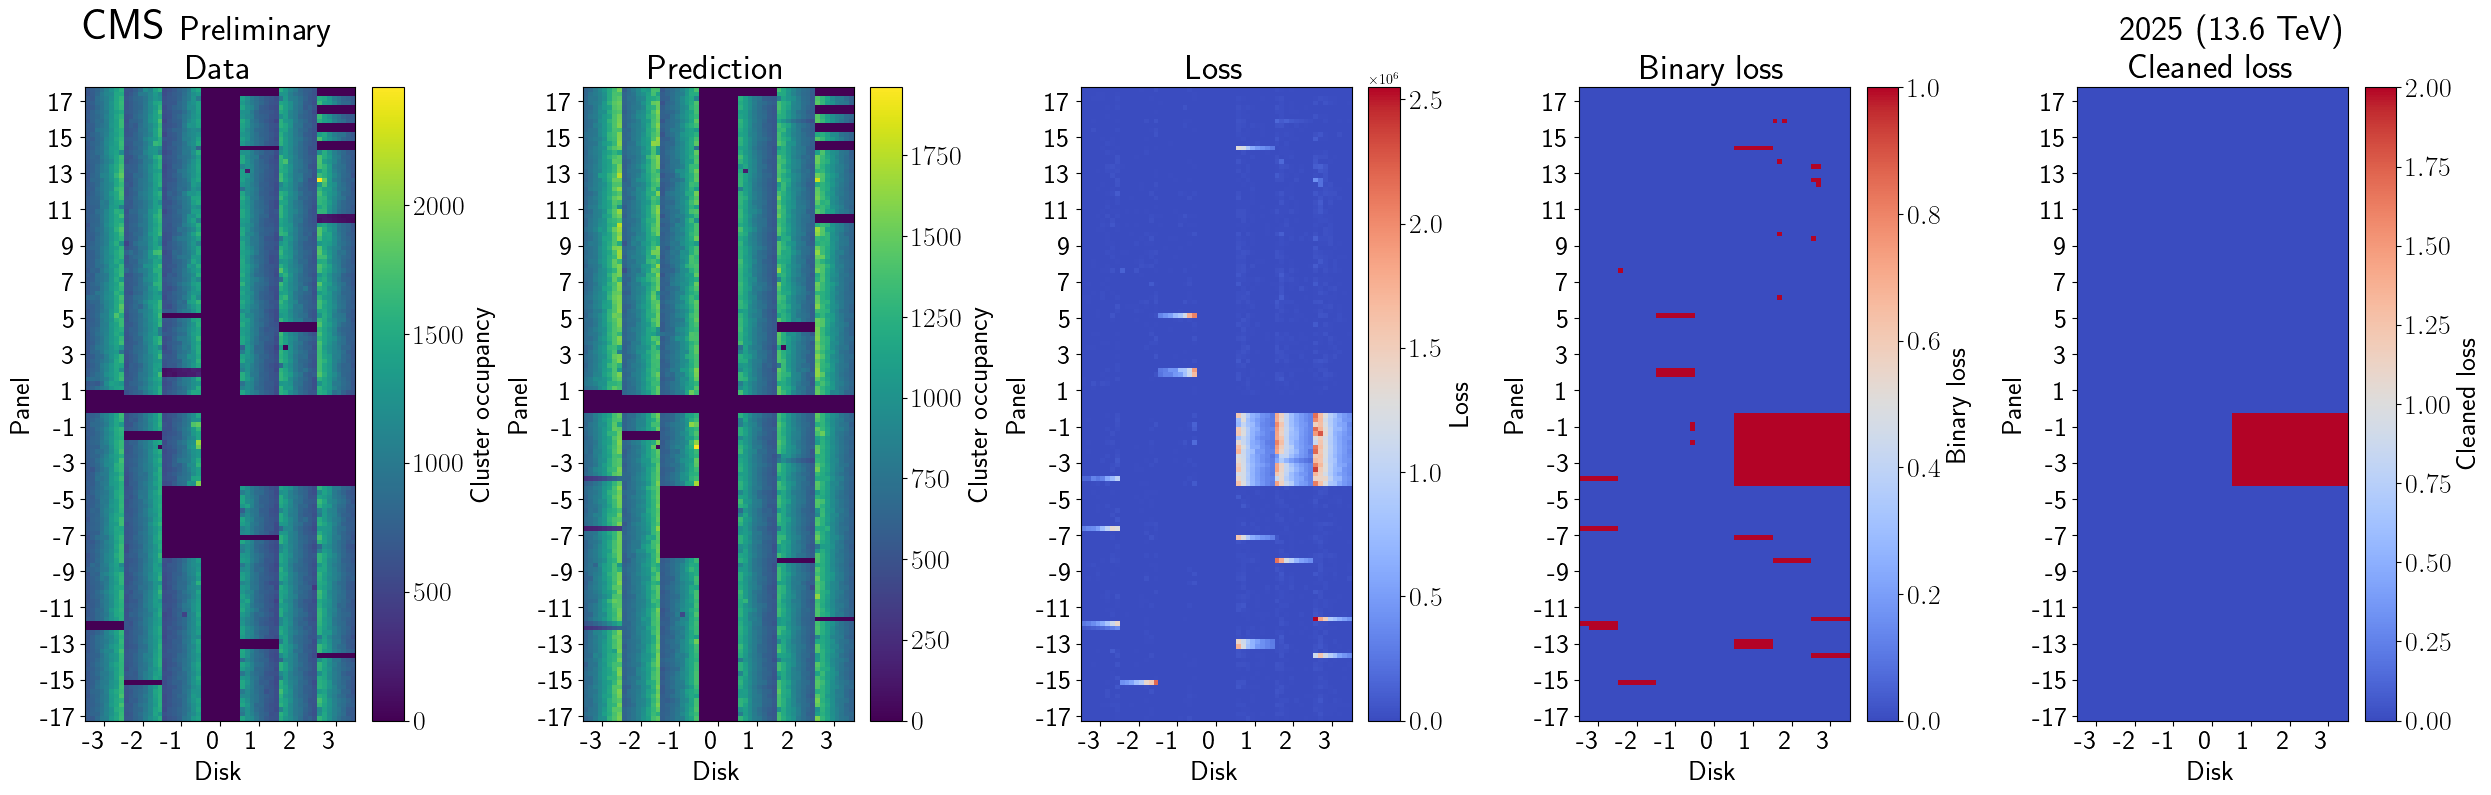

In [10]:
#%%skip True
#%%time
#Inspect the original data, the prediction, the loss, and the binary loss

#YEAR, ERA, VERSION, PERIOD = 2025, "C", 1, 3
#run_number = 392295
#lumi_number = 169

#YEAR, ERA, VERSION, PERIOD = 2025, "F", 1, 4
run_number = 396871
lumi_number = 743

#YEAR, ERA, VERSION, PERIOD = 2024, "I", 2, 2
#run_number = 386704
#lumi_number = 15


verbose = 1
save_fig = False

#Find the data_dict with a run number of run_number and extract the relevant information
#https://stackoverflow.com/questions/8653516/search-a-list-of-dictionaries-in-python. See here
plot_dict = next((data_dict for data_dict in data_dict_list if data_dict["run_number"] == run_number), None)
if plot_dict == None:
    raise Exception(f"Run Number {run_number} is not in the list of dictionaries!")

#Extract the relavant information for plotting
lumisections = plot_dict['lumisections']
if verbose>1: print(f"There are {len(lumisections)} Available Lumisections:\n{lumisections}")
multi_lumi_data = plot_dict['data_cross']
mes_pred_cross = plot_dict['predictions_cross']
losses_cross = plot_dict['losses']
losses_binary_cross = plot_dict['losses_binary']

#Extract the anomalous powergroups in that lumisection
anomalous_lumisections = plot_dict['anomalous_lumisections'] #anomalous_lumisections is a comprehensive list of anomalous lumisections, 
#Containing duplicates for lumisections with multiple anomalous powergroups
desired_lumi_indices = np.where(anomalous_lumisections == lumi_number)[0] #np.where needs this extra [0]
anomalous_powergroups = plot_dict['anomalous_powergroups']
desired_anomalous_powergroups = anomalous_powergroups[desired_lumi_indices]


#Extract the specific lumisection data
index = lumiToIndex(lumisections, lumi_number)
data = multi_lumi_data[index]
prediction = mes_pred_cross[index]
plot_losses = losses_cross[index]
plot_losses_binary = losses_binary_cross[index]
if verbose>0: print(f"All Anomalous Powergroups in This Lumisection: {desired_anomalous_powergroups}")


print(f"Run Number: {run_number}\tLumi Number: {lumi_number}")
#testingFig, testingAxes = plot_testing_plots(data, prediction, plot_losses, 
#                                             plot_losses_binary, run_number, lumi_number, ring_num, 
#                                             saveFig=save_fig, showFig=True)

import functions
importlib.reload(functions);
from functions import *

testingFig, testingAxes = plot_public_plots(data, prediction, plot_losses, plot_losses_binary, desired_anomalous_powergroups,
                                            run_number, lumi_number, ring_num,
                                            saveFig=save_fig, showFig=True)

plt.show()

## 10. Optional (Save plot of each anomalous lumisection)

In [ ]:
%%skip True
%%time

doPlotting = DO_PLOTTING
saveFigs = SAVE_FIGS
showFigs = SHOW_FIGS
verbose = 1
imageDir = f"images/{DIR_NAME}"
if saveFigs: 
    #Ensure the saving directory exists
    if not os.path.exists(f"images/{DIR_NAME}"): os.makedirs(f"images/{DIR_NAME}")
    print(f"Images will be saved in: {imageDir}")
#Create lists for tracking the anomalous lumisections in all of the runs
# all_anomalous_runs
# all_anomalous_lumisections
# all_anomalous_lumisections_unique
# all_anomalous_powergroups
# total_anomalous_lumisections = len(all_anomalous_lumisections_unique) Either one works
total_anomalous_lumisections = num_anomalous_lumisections
#Inspect the original data, the prediction, the loss, and the binary loss
print(f"There are {total_anomalous_lumisections} anomalous lumisections from run {all_runs[0]} to run {all_runs[-1]}!")
#print(f"The anomalous powergroups are:\n{anomalous_powergroups}\n")
counter = 0 #Counter for keeping track of if we're almost done
previous_counter = 0 #Just used to make the print statements cleaner. Only print progress if the data_dict actually had an anomalous lumisection
for i, data_dict in enumerate(data_dict_list):
    startTime = time.time()
    #Extract the relevant information from the data_dict
    run_number = data_dict['run_number']
    lumisections = data_dict['lumisections']
    multi_lumi_data = data_dict['data_cross']
    mes_pred_cross = data_dict['predictions_cross']
    losses_cross = data_dict['losses']
    losses_binary_cross = data_dict['losses_binary']
    anomalous_lumisections = data_dict['anomalous_lumisections']
    anomalous_powergroups = data_dict['anomalous_powergroups']
    
    previous_lumisection = -1
    for j, lumisection in enumerate(anomalous_lumisections):
        counter += 1 #Increase the counter for each anomalous lumisection plotted
        index = lumiToIndex(lumisections, lumisection)
        data = multi_lumi_data[index]
        prediction = mes_pred_cross[index]
        plot_losses = losses_cross[index]
        plot_losses_binary = losses_binary_cross[index]
        anomalous_powergroup = anomalous_powergroups[j]

        if verbose>1: print(f"Anomalous Power Group: {anomalous_powergroup} \t in Lumisection: {lumisection} \t in Run: {run_number}")
        #Plotting and determining whether the current lumisection is the same as the previous one due to multi disk anomalies
        if doPlotting and lumisection != previous_lumisection: #only print if the current lumisection is not the previous one again
            testingFig, testingAxes = plot_testing_plots(data, prediction, plot_losses, plot_losses_binary, run_number, lumisection, ring_num, 
                                                         directory=imageDir, saveFig=saveFigs, showFig=showFigs)
            #plt.show()
            if verbose>0 and showFigs: 
                print(f"The Anomalous Powergroup in the Above Image is: {anomalous_powergroup}")
        elif doPlotting and lumisection == previous_lumisection:
            if verbose>0 and showFigs: print(f"Due to a Multi-Disk Anomaly, the Other Anomalous Powergroup is: {anomalous_powergroup}")
        
        previous_lumisection = lumisection
    #If verbose and there was an anomalous lumisection in that run
    if verbose>0 and counter != previous_counter: print(f"Done Run {run_number} and {counter}/{total_anomalous_lumisections} Anomalous Lumisections in {time.time()-startTime} Seconds!")
    previous_counter = counter